In [61]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*5
presets = 'best_quality'

do_drop_ds = True
# hour, dayofweek, dayofmonth, month, year
use_dt_attrs = []#["hour", "year"]
use_estimated_diff_attr = False
use_is_estimated_attr = True

use_groups = False
n_groups = 8

auto_stack = False
num_stack_levels = 0
num_bag_folds = 0
num_bag_sets = 0

use_tune_data = True
use_test_data = True
tune_and_test_length = 24*30*6 # 3 months from end
holdout_frac = None
use_bag_holdout = True # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = None#'sample_weight' #None
weight_evaluation = False
sample_weight_estimated = 1

run_analysis = False

In [62]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift all columns with "1h" in them by 1 hour, so that for index 16:00, we have the values from 17:00
    # but only for the columns with "1h" in the name
    #X_shifted = X.filter(regex="\dh").shift(-1, axis=1)
    #print(f"Number of columns with 1h in name: {X_shifted.columns}")


    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm']
    
    X_shifted = X[X.index.minute==0][columns].copy()
    # loop through all rows and check if index + 1 hour is in the index, if so get that value, else nan
    count1 = 0
    count2 = 0
    for i in range(len(X_shifted)):
        if X_shifted.index[i] + pd.Timedelta('1 hour') in X.index:
            count1 += 1
            X_shifted.iloc[i] = X.loc[X_shifted.index[i] + pd.Timedelta('1 hour')][columns]
        else:
            count2 += 1
            X_shifted.iloc[i] = np.nan

    print("COUNT1", count1)
    print("COUNT2", count2)

    X_old_unshifted = X[X.index.minute==0][columns]
    # rename X_old_unshifted columns to have _not_shifted at the end
    X_old_unshifted.columns = [f"{col}_not_shifted" for col in X_old_unshifted.columns]

    # put the shifted columns back into the original dataframe
    #X[columns] = X_shifted[columns]

    

    date_calc = None
    if "date_calc" in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']

    # resample to hourly
    print("index: ", X.index[0])
    X = X.resample('H').mean()
    print("index AFTER: ", X.index[0])

    X[columns] = X_shifted[columns]
    #X[X_old_unshifted.columns] = X_old_unshifted

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    if weight_evaluation:
        # add sample weights, which are 1 for observed and 3 for estimated
        X_train_observed["sample_weight"] = 1
        X_train_estimated["sample_weight"] = sample_weight_estimated
        X_test["sample_weight"] = sample_weight_estimated


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_estimated_diff_attr:
        X_train_observed["estimated_diff_hours"] = 0
        X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
        X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

        X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
        # the filled once will get dropped later anyways, when we drop y nans
        X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')
    
    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1

    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
COUNT1 29667
COUNT2 1
index:  2019-06-02 22:00:00
index AFTER:  2019-06-02 22:00:00
COUNT1 4392
COUNT2 2
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
COUNT1 702
COUNT2 18
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 0
Processing location B...
COUNT1 29232
COUNT2 1
index:  2019-01-01 00:00:00
index AFTER:  2019-01-01 00:00:00
COUNT1 4392
COUNT2 2
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
COUNT1 702
COUNT2 18
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 4
Processing location C...
COUNT1 29206
COUNT2 1
index:  2019-01-01 00:00:00
index AFTER:  2019-01-01 00:00:00
COUNT1 4392
COUNT2 2
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
COUNT1 702
COUNT2 18
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 6059


# Feature enginering

In [63]:
import numpy as np
import pandas as pd

X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)


for attr in use_dt_attrs:
    X_train[attr] = getattr(X_train.index, attr)
    X_test[attr] = getattr(X_test.index, attr)

print(X_train.head())




if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())





to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

                     absolute_humidity_2m:gm3  air_density_2m:kgm3  \
ds                                                                   
2019-06-02 22:00:00                     7.700              1.22825   
2019-06-02 23:00:00                     7.700              1.22350   
2019-06-03 00:00:00                     7.875              1.21975   
2019-06-03 01:00:00                     8.425              1.21800   
2019-06-03 02:00:00                     8.950              1.21800   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
ds                                                                 
2019-06-02 22:00:00           1728.949951               0.000000   
2019-06-02 23:00:00           1689.824951               0.000000   
2019-06-03 00:00:00           1563.224976               0.000000   
2019-06-03 01:00:00           1283.425049            6546.899902   
2019-06-03 02:00:00           1003.500000          102225.898438   

                     clear_sky_r

In [64]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import numpy as np
train_data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data = train_data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
#split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_and_test_length)
# 2022-10-28 22:00:00
split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(train_data[train_data["ds"] < split_time])
test_set = TabularDataset(train_data[train_data["ds"] >= split_time])
if use_groups:
    test_set = test_set.drop(columns=['group'])

if do_drop_ds:
    train_set = train_set.drop(columns=['ds'])
    test_set = test_set.drop(columns=['ds'])
    train_data = train_data.drop(columns=['ds'])


def normalize_sample_weights_per_location(df):
    for loc in locations:
        loc_df = df[df["location"] == loc]
        loc_df["sample_weight"] = loc_df["sample_weight"] / loc_df["sample_weight"].sum() * loc_df.shape[0]
        df[df["location"] == loc] = loc_df
    return df

tuning_data = None
if use_tune_data:
    train_data = train_set
    if use_test_data:
        # split test_set in half, use first half for tuning
        tuning_data, test_data = [], []
        for loc in locations:
            loc_test_set = test_set[test_set["location"] == loc]
            # randomly shuffle the loc_test_set
            loc_tuning_data, loc_test_data = pd.DataFrame(), pd.DataFrame()
            for i in range(200):
                # get a part of the test set corresponding to i/100th part of the test set and shuffle
                num_bins = len(loc_test_set) // 200
                # set seed to i so that we get the same shuffle every time
                np.random.seed(i)
                current_bin = loc_test_set.iloc[i*num_bins:min((i+1)*num_bins, len(loc_test_set))].sample(frac=1)
                loc_tuning_data = pd.concat([loc_tuning_data, current_bin.iloc[:len(current_bin)//2]])
                loc_test_data = pd.concat([loc_test_data, current_bin.iloc[len(current_bin)//2:]])

            tuning_data.append(loc_tuning_data)
            test_data.append(loc_test_data)
        tuning_data = pd.concat(tuning_data)
        test_data = pd.concat(test_data)
        print("Shapes of tuning and test", tuning_data.shape[0], test_data.shape[0], tuning_data.shape[0] + test_data.shape[0])

    else:
        tuning_data = test_set
        print("Shape of tuning", tuning_data.shape[0])
    
    # ensure sample weights for your tuning data sum to the number of rows in the tuning data.
    if weight_evaluation:
        tuning_data = normalize_sample_weights_per_location(tuning_data)

    
else:
    if use_test_data:
        train_data = train_set
        test_data = test_set
        print("Shape of test", test_data.shape[0])

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
if weight_evaluation:
    train_data = normalize_sample_weights_per_location(train_data)
    if use_test_data:
        test_data = normalize_sample_weights_per_location(test_data)


train_data = TabularDataset(train_data)
if use_tune_data:
    tuning_data = TabularDataset(tuning_data)
if use_test_data:
    test_data = TabularDataset(test_data)

Loaded data from: X_train_raw.csv | Columns = 40 / 40 | Rows = 92945 -> 92945


Shapes of tuning and test 5000 5400 10400


In [65]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=train_data, test_data=test_data, label="y", sample=None)

In [66]:
if run_analysis:
    auto.target_analysis(train_data=train_data, label="y", sample=None)

# Starting

In [67]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 85
Now creating submission number: 86
New filename: submission_86_jorge


In [68]:
predictors = [None, None, None]

In [69]:
def fit_predictor_for_location(loc):
    print(f"Training model for location {loc}...")
    # sum of sample weights for this location, and number of rows, for both train and tune data and test data
    if weight_evaluation:
        print("Train data sample weight sum:", train_data[train_data["location"] == loc]["sample_weight"].sum())
        print("Train data number of rows:", train_data[train_data["location"] == loc].shape[0])
        if use_tune_data:
            print("Tune data sample weight sum:", tuning_data[tuning_data["location"] == loc]["sample_weight"].sum())
            print("Tune data number of rows:", tuning_data[tuning_data["location"] == loc].shape[0])
        if use_test_data:
            print("Test data sample weight sum:", test_data[test_data["location"] == loc]["sample_weight"].sum())
            print("Test data number of rows:", test_data[test_data["location"] == loc].shape[0])
    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
        # sample_weight=sample_weight, 
        # weight_evaluation=weight_evaluation, 
        # groups="group" if use_groups else None,
    ).fit(
        train_data=train_data[train_data["location"] == loc],
        time_limit=time_limit, 
        presets=presets, 
        # num_stack_levels=num_stack_levels,
        # num_bag_folds=num_bag_folds if not use_groups else 2,# just put somethin, will be overwritten anyways
        # num_bag_sets=num_bag_sets,
        tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True) if use_tune_data else None,
        use_bag_holdout=use_bag_holdout,
        # holdout_frac=holdout_frac,
    )

    # evaluate on test data
    if use_test_data:
        # drop sample_weight column
        t = test_data[test_data["location"] == loc]#.drop(columns=["sample_weight"])
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/submission_86_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   195.44 GB / 494.38 GB (39.5%)
Train Data Rows:    29667
Train Data Columns: 38
Tuning Data Rows:    2000
Tuning Data Columns: 38
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 674.14552, 1195.53172)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor in

Training model for location A...


	-133.6185	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	117.37s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 72.48s of the 172.49s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 96.15s compared to 94.2s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 70.82s of the 170.83s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1031. Best iteration is:
	[1031]	valid_set's l1: 176.296


[1000]	valid_set's l1: 176.582


	Ran out of time, early stopping on iteration 1021. Best iteration is:
	[1018]	valid_set's l1: 179.594


[1000]	valid_set's l1: 179.72
[1000]	valid_set's l1: 181.239


	Ran out of time, early stopping on iteration 1161. Best iteration is:
	[1161]	valid_set's l1: 179.762


[1000]	valid_set's l1: 192.852


	Ran out of time, early stopping on iteration 1209. Best iteration is:
	[1207]	valid_set's l1: 191.26


[1000]	valid_set's l1: 183.415


	Ran out of time, early stopping on iteration 1330. Best iteration is:
	[1328]	valid_set's l1: 181.52


[1000]	valid_set's l1: 187.371


	Ran out of time, early stopping on iteration 1346. Best iteration is:
	[1341]	valid_set's l1: 184.227


[1000]	valid_set's l1: 183.28


	Ran out of time, early stopping on iteration 1513. Best iteration is:
	[1512]	valid_set's l1: 179.883


[1000]	valid_set's l1: 174.309


	Ran out of time, early stopping on iteration 1739. Best iteration is:
	[1738]	valid_set's l1: 169.152
	-107.8553	 = Validation score   (-mean_absolute_error)
	67.49s	 = Training   runtime
	0.34s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 2.29s of the 102.3s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's l1: 531.54
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	valid_set's l1: 502.472
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's l1: 500.675
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's l1: 500.15
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's l1: 529.894
	Ran out of time, early stopping on iteration 14. Best iteration is:
	[14]	valid_set's l1: 497.618
	Ra

[1000]	valid_set's l1: 174.446
[2000]	valid_set's l1: 173.247


	Ran out of time, early stopping on iteration 2168. Best iteration is:
	[1917]	valid_set's l1: 173.081


[1000]	valid_set's l1: 171.461


	-105.2716	 = Validation score   (-mean_absolute_error)
	45.38s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 35.57s of the 35.56s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-106.7829	 = Validation score   (-mean_absolute_error)
	14.21s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 21.2s of the 21.19s of remaining time.
	-104.9627	 = Validation score   (-mean_absolute_error)
	25.36s	 = Training   runtime
	0.74s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 299.87s of the -5.41s of remaining time.
	-104.4361	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 305.47s ... Best model: "WeightedEnsemble_L3"
TabularPred

Evaluation on test data:
-113.16885438634273


In [70]:
leaderboards = []
if use_test_data:
    lb = predictors[0].leaderboard(test_data[test_data["location"] == loc])
    lb["location"] = loc
    leaderboards.append(lb)
    test_data[test_data["location"] == loc]["y"].plot()
    if use_tune_data:
        tuning_data[tuning_data["location"] == loc]["y"].plot()

                    model  score_test   score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3 -113.168854 -104.436093       15.774885     119.292512  157.822212                 0.002436                0.000205           0.036211            3       True          9
1  RandomForestMSE_BAG_L2 -113.679430 -104.962677       15.627173     119.095505  112.410656                 0.265204                0.736245          25.360664            2       True          8
2     WeightedEnsemble_L2 -114.695811 -107.818004       15.349949     118.340226   84.905910                 0.002343                0.000179           0.045097            2       True          5
3       LightGBMXT_BAG_L2 -114.700238 -105.271560       15.507245     118.556062  132.425337                 0.145276                0.196802          45.375345            2       True          6
4         LightGBM_B

Timestamp('2022-10-28 22:00:00')

In [72]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/submission_86_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   195.36 GB / 494.38 GB (39.5%)
Train Data Rows:    29218
Train Data Columns: 38
Tuning Data Rows:    1600
Tuning Data Columns: 38
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, 0.0, 102.58516, 198.99359)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init

Training model for location B...


			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['elevation:m', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 35 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 35 | ['absolute_humidity_2m:gm3', 'air_density_2m:kg

[1000]	valid_set's l1: 36.3802


	Ran out of time, early stopping on iteration 1111. Best iteration is:
	[1110]	valid_set's l1: 36.1477
	-20.1988	 = Validation score   (-mean_absolute_error)
	36.29s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 1.2s of the 101.2s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's l1: 129.152
	Time limit exceeded... Skipping LightGBM_BAG_L1.
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 1.01s of the 101.02s of remaining time.
	-19.0505	 = Validation score   (-mean_absolute_error)
	22.43s	 = Training   runtime
	0.63s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.88s of the 77.51s of remaining time.
	-19.0344	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtim

[1000]	valid_set's l1: 32.4013


	Ran out of time, early stopping on iteration 1442. Best iteration is:
	[1442]	valid_set's l1: 32.0834


[1000]	valid_set's l1: 33.5065


	Ran out of time, early stopping on iteration 1461. Best iteration is:
	[1452]	valid_set's l1: 33.2677


[1000]	valid_set's l1: 32.8849


	Ran out of time, early stopping on iteration 1383. Best iteration is:
	[1383]	valid_set's l1: 32.6016


[1000]	valid_set's l1: 32.7674


	Ran out of time, early stopping on iteration 1911. Best iteration is:
	[1826]	valid_set's l1: 32.3882


[1000]	valid_set's l1: 32.7049
[2000]	valid_set's l1: 32.1022


	Ran out of time, early stopping on iteration 2424. Best iteration is:
	[2424]	valid_set's l1: 31.8366


[1000]	valid_set's l1: 31.0006
[2000]	valid_set's l1: 30.448


	Ran out of time, early stopping on iteration 2308. Best iteration is:
	[2273]	valid_set's l1: 30.3372


[1000]	valid_set's l1: 32.4719
[2000]	valid_set's l1: 31.9066


	Ran out of time, early stopping on iteration 2672. Best iteration is:
	[2666]	valid_set's l1: 31.6745
	-20.4871	 = Validation score   (-mean_absolute_error)
	73.29s	 = Training   runtime
	0.47s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 2.83s of the 2.82s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 22. Best iteration is:
	[22]	valid_set's l1: 59.5569
	Ran out of time, early stopping on iteration 28. Best iteration is:
	[28]	valid_set's l1: 52.671
	Ran out of time, early stopping on iteration 25. Best iteration is:
	[25]	valid_set's l1: 55.2484
	Ran out of time, early stopping on iteration 26. Best iteration is:
	[26]	valid_set's l1: 54.0232
	Ran out of time, early stopping on iteration 26. Best iteration is:
	[26]	valid_set's l1: 53.6851
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[34]	valid_set's l1: 45.8969
	Ran

Evaluation on test data:
-20.578931654164496


In [ ]:
if use_test_data:
    lb = predictors[1].leaderboard(test_data[test_data["location"] == loc])
    test_data[test_data["location"] == loc]["y"].plot()
    lb["location"] = loc
    leaderboards.append(lb)
    if use_tune_data:
        tuning_data[tuning_data["location"] == loc]["y"].plot()

                    model  score_test   score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3 -113.168854 -104.436093       15.774885     119.292512  157.822212                 0.002436                0.000205           0.036211            3       True          9
1  RandomForestMSE_BAG_L2 -113.679430 -104.962677       15.627173     119.095505  112.410656                 0.265204                0.736245          25.360664            2       True          8
2     WeightedEnsemble_L2 -114.695811 -107.818004       15.349949     118.340226   84.905910                 0.002343                0.000179           0.045097            2       True          5
3       LightGBMXT_BAG_L2 -114.700238 -105.271560       15.507245     118.556062  132.425337                 0.145276                0.196802          45.375345            2       True          6
4         LightGBM_B

Timestamp('2022-10-28 22:00:00')

In [73]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/submission_86_jorge_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   194.80 GB / 494.38 GB (39.4%)
Train Data Rows:    23141
Train Data Columns: 38
Tuning Data Rows:    1400
Tuning Data Columns: 38
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, 0.0, 82.28807, 171.35018)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor i

Training model for location C...


	-23.8716	 = Validation score   (-mean_absolute_error)
	0.01s	 = Training   runtime
	98.69s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 91.4s of the 191.42s of remaining time.
	-24.1578	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	133.99s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.91s of the 39.45s of remaining time.
	-23.8716	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 39.42s of the 39.41s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 627. Best iteration is:
	[627]	valid_set's l1: 19.7863
	Ran out of time, early stopping on iteration 653. Best iteration is:
	[653]	valid_set's l1

[1000]	valid_set's l1: 20.0895
[1000]	valid_set's l1: 20.403


	Ran out of time, early stopping on iteration 1060. Best iteration is:
	[1060]	valid_set's l1: 20.3218


[1000]	valid_set's l1: 20.5167


	Ran out of time, early stopping on iteration 1182. Best iteration is:
	[1181]	valid_set's l1: 20.254
	-20.8723	 = Validation score   (-mean_absolute_error)
	37.55s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 1.24s of the 1.24s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's l1: 107.41
	Time limit exceeded... Skipping LightGBM_BAG_L2.
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 1.07s of the 1.06s of remaining time.
	-20.6181	 = Validation score   (-mean_absolute_error)
	11.17s	 = Training   runtime
	0.43s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 299.91s of the -10.83s of remaining time.
	-20.4289	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtime
	0

Evaluation on test data:
-20.537568456421482


In [ ]:
if use_test_data:
    lb = predictors[2].leaderboard(test_data[test_data["location"] == loc])
    test_data[test_data["location"] == loc]["y"].plot()
    lb["location"] = loc
    leaderboards.append(lb)
    if use_tune_data:
        tuning_data[tuning_data["location"] == loc]["y"].plot()

                    model  score_test   score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3 -113.168854 -104.436093       15.774885     119.292512  157.822212                 0.002436                0.000205           0.036211            3       True          9
1  RandomForestMSE_BAG_L2 -113.679430 -104.962677       15.627173     119.095505  112.410656                 0.265204                0.736245          25.360664            2       True          8
2     WeightedEnsemble_L2 -114.695811 -107.818004       15.349949     118.340226   84.905910                 0.002343                0.000179           0.045097            2       True          5
3       LightGBMXT_BAG_L2 -114.700238 -105.271560       15.507245     118.556062  132.425337                 0.145276                0.196802          45.375345            2       True          6
4         LightGBM_B

Timestamp('2022-10-28 22:00:00')

In [ ]:
# save leaderboards to csv
leaderboards = pd.concat(leaderboards)
leaderboards.to_csv(f"leaderboards/{new_filename}.csv")

# Submit

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 40 / 40 | Rows = 92945 -> 92945
Loaded data from: X_test_raw.csv | Columns = 39 / 39 | Rows = 4608 -> 4608


In [75]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [76]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    past_pred = predictors[i].predict(train_data_with_dates[train_data_with_dates["location"] == loc])
    train_data_with_dates.loc[train_data_with_dates["location"] == loc, "prediction"] = past_pred
    

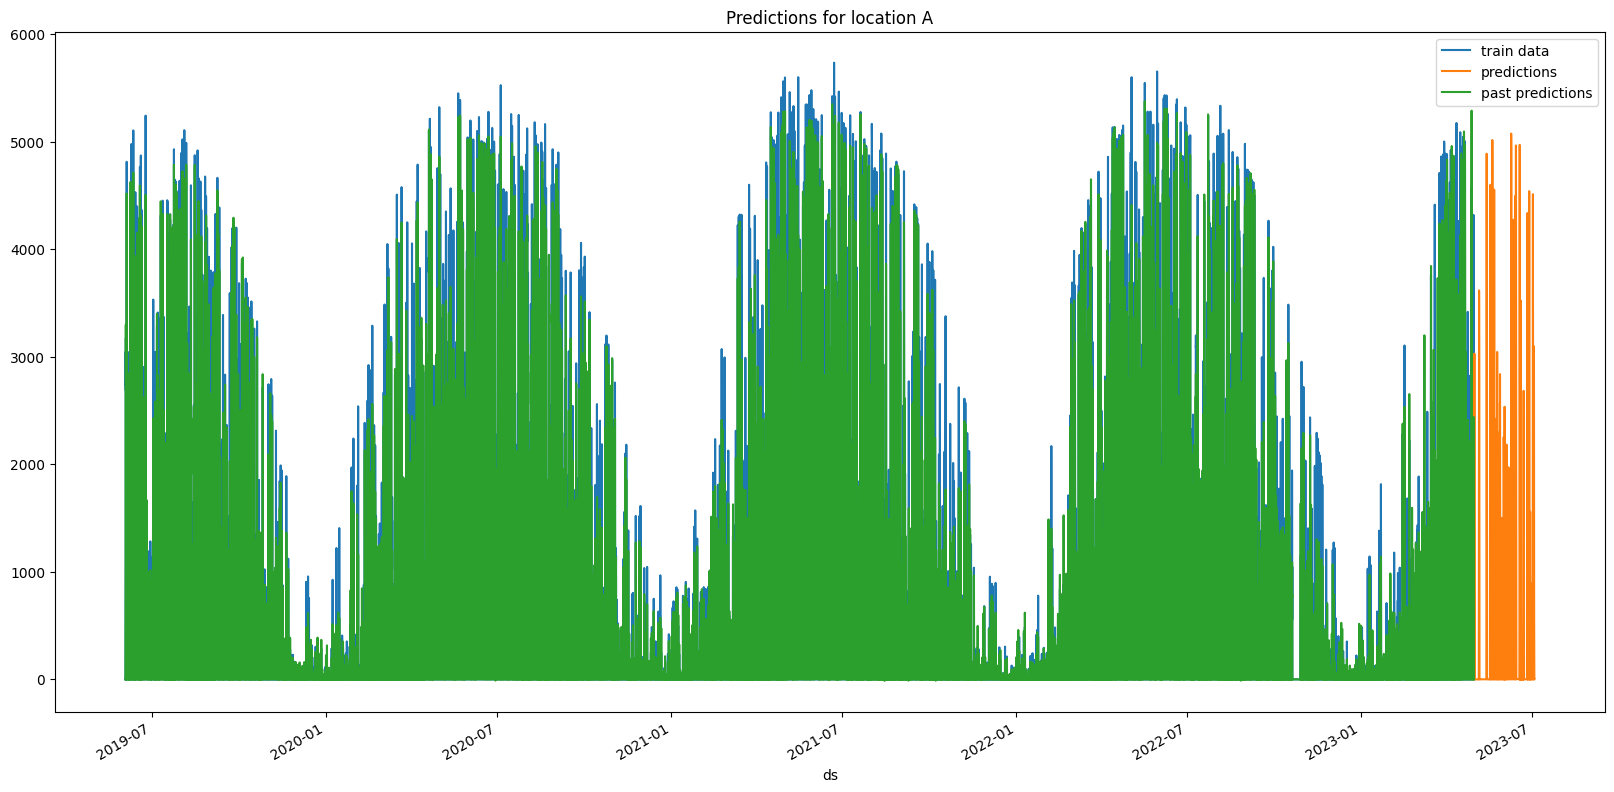

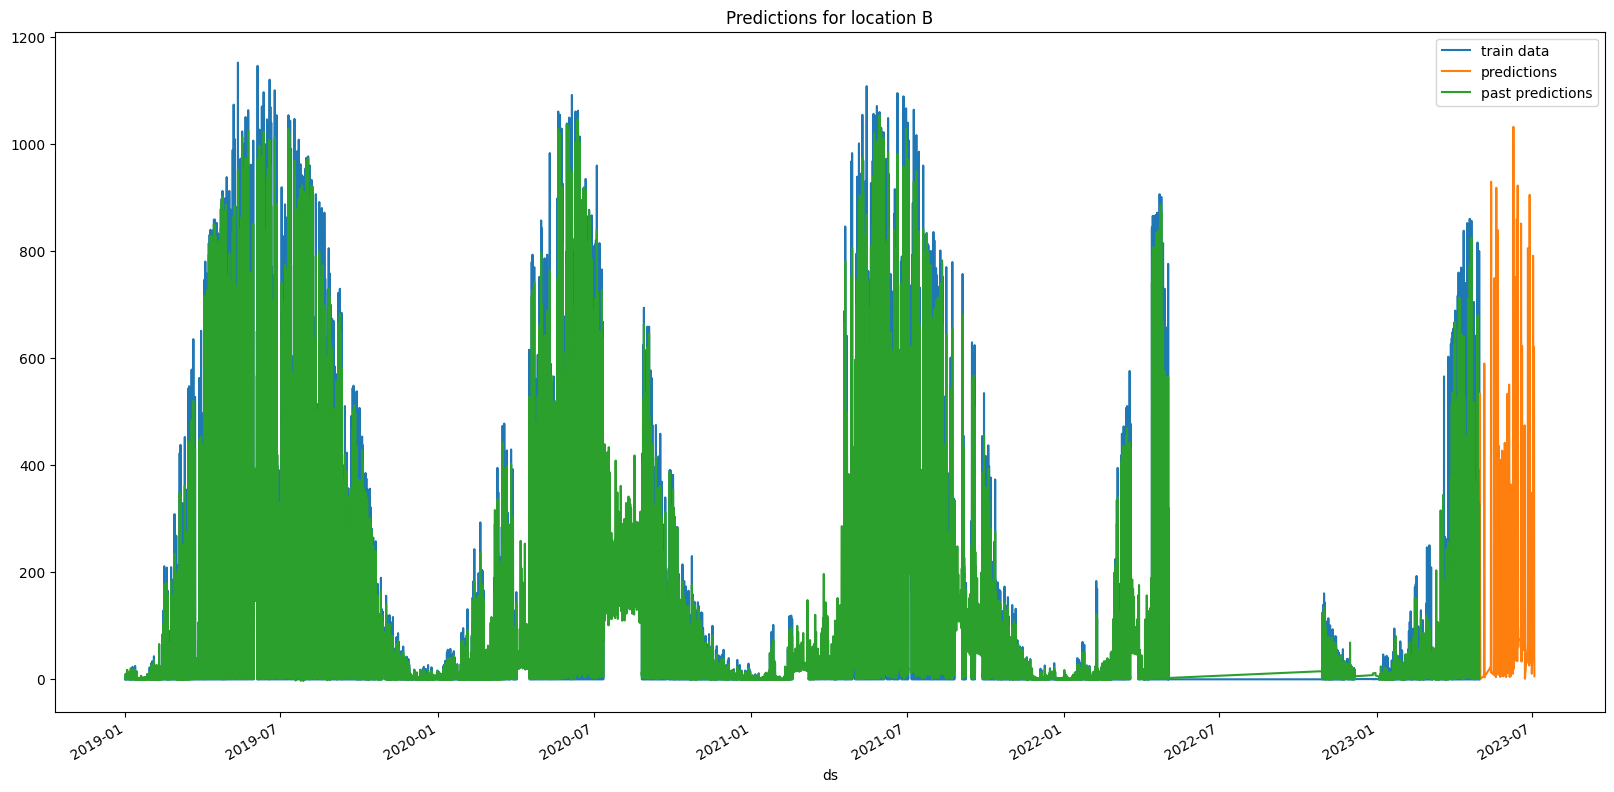

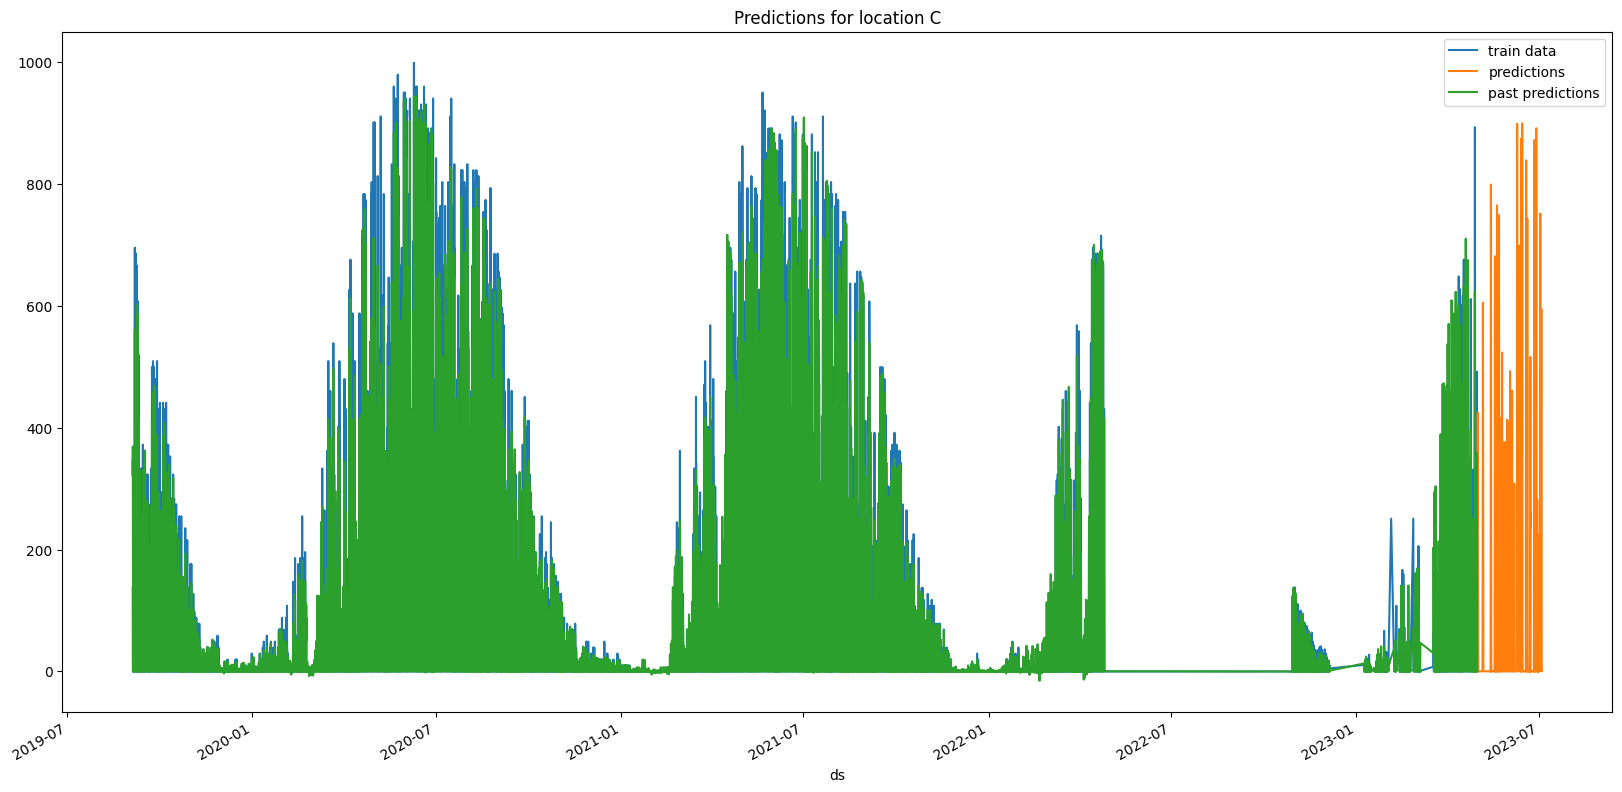

In [77]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [78]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,0.190750
1,1,0.172260
2,2,0.253748
3,3,72.893936
4,4,287.815857
...,...,...
715,2155,51.404938
716,2156,15.884264
717,2157,0.688623
718,2158,0.341778


In [79]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

Saving submission to submissions/submission_86_jorge.csv
jall1a


In [80]:
# save this running notebook
from IPython.display import display, Javascript
import time

# hei123

display(Javascript("IPython.notebook.save_checkpoint();"))

time.sleep(3)

<IPython.core.display.Javascript object>

In [81]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_86_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_86_jorge_files/notebook_pdfs
[NbConvertApp] Writing 147932 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 353280 bytes to notebook_pdfs/submission_86_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_86_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [82]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'location', 'prediction']


Computing feature importance via permutation shuffling for 36 features using 4392 rows with 10 shuffle sets... Time limit: 600s...
	5679.76s	= Expected runtime (567.98s per shuffle set)


In [ ]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*10)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # feature importance                                                                         │
│   2 observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]                   │
│   3 observed = observed[observed["location"] == location]                                        │
│ ❱ 4 predictors[0].feature_importance(feature_stage="original", data=observed, time_limit=60*     │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'feature_importance'

In [ ]:
display(Javascript("IPython.notebook.save_checkpoint();"))
time.sleep(3)

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_85_jorge_with_feature_importance_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_85_jorge_with_feature_importance_files/notebook_pdfs
[NbConvertApp] Writing 207350 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 display(Javascript("IPython.notebook.save_checkpoint();"))                                   │
│   2 time.sleep(3)                                                                                │
│   3                                                                                              │
│ ❱ 4 subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('noteboo     │
│   5                                                                                              │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.py:505 in run                          │
│                                                                                                  │
│    502 │                                                                                         │
│    503 │   with Popen(*popenargs, **kwargs) as process:                                          │
│    504 │   │   try:                                                                              │
│ ❱  505 │   │   │   stdout, stderr = process.communicate(input, timeout=timeout)                  │
│    506 │   │   except TimeoutExpired as exc:                                                     │
│    507 │   │   │   process.kill()                                                                │
│    508 │   │   │   if _mswindows:                                                                │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.py:1146 in communicate                 │
│                                                                                                  │
│   1143 │   │   │   elif self.stderr:                                                             │
│   1144 │   │   │   │   stderr = self.stderr.read()                                               │
│   1145 │   │   │   │   self.stderr.close()                                                       │
│ ❱ 1146 │   │   │   self.wait()                                                                   │
│   1147 │   │   else:                                                                             │
│   1148 │   │   │   if timeout is not None:                                                       │
│   1149 │   │   │   │   endtime = _time() + timeout                                               │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.py:1209 in wait                        │
│                                                                                                  │
│   1206 │   │   if timeout is not None:                                                           │
│   1207 │   │   │   endtime = _time() + timeout                                                   │
│   1208 │   │   try:                                                                              │
│ ❱ 1209 │   │   │   return self._wait(timeout=timeout)                                            │
│   1210 │   │   except KeyboardInterrupt:                                                         │
│   1211 │   │   │   # https://bugs.python.org/issue25942                                          │
│   1212 │   │   │   # The first keyboard interrupt waits briefly for the child to                 │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/subprocess.p

In [ ]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])